In [6]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)

{'acknowledged': True,
 'index': 'tp5-championstweet',
 'shards_acknowledged': True}


In [7]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("dataset")
pprint(len(files))

354587


In [8]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('dataset/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-championstweet", doc_type="_doc")
        tweets=[]

KeyboardInterrupt: 

In [9]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print(hit)

Got 120000 Hits:
{'_source': {'location': 'Köln, Deutschland', 'timestamp': 1527365121949, 'date': 'Sat May 26 20:05:21 +0000 2018', 'username': 'LikeaMalte', 'text': 'RT @supermxy: Der weinende Salah bricht mir das Herz. Die Saison seines Lebens, im wohlverdienten Champions League stehen und dann ist alle…'}, '_index': 'tp5-championstweet', '_id': 'Ceo2gGQBK0BPj9HvA2Hk', '_score': 1.0, '_type': '_doc'}
{'_source': {'location': 'Bangkok, Thailand', 'timestamp': 1527365297955, 'date': 'Sat May 26 20:08:17 +0000 2018', 'username': 'Chantima', 'text': 'RT @duanzjira: นี่นอนดูไม่ได้ละ  😆 \n#UCLfinal \n#YNWA #LIVERPOOL #LFC #UCL #ChampionsLeagueFinal #LFCThai'}, '_index': 'tp5-championstweet', '_id': 'Euo2gGQBK0BPj9HvA2Hk', '_score': 1.0, '_type': '_doc'}
{'_source': {'location': None, 'timestamp': 1527360433330, 'date': 'Sat May 26 18:47:13 +0000 2018', 'username': 'Samu', 'text': 'RT @tresparaum: COMEÇA O JOGO! COMEÇA O ESPETÁCULO!\n\n#UCLfinal #UCLFinal2018 https://t.co/dZCytwwNbR'}, '_i

In [68]:
#CONSULTA: ¿Cuántos tweets cada minuto?
res = es.search(index="tp5-championstweet", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
#for data in res['aggregations']['tweets_over_time']['buckets']:
#    print(data['doc_count'])

In [12]:
#buscar por termino
res = es.search(index="tp5-championstweet", body=
{
    "query" : {
        "term" : { "text" : "liverpool" }
    }
})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    pprint(hit)

Got 14996 Hits:
{'_id': '7us5gGQBK0BPj9HvYFIq',
 '_index': 'tp5-championstweet',
 '_score': 4.0513315,
 '_source': {'date': 'Sat May 26 18:53:02 +0000 2018',
             'location': 'Niall follows!!',
             'text': 'LIVERPOOL LIVERPOOL LIVERPOOL LIVERPOOL LIVERPOOL  '
                     '#UCLfinal',
             'timestamp': 1527360782916,
             'username': 'M 🕊'},
 '_type': '_doc'}
{'_id': '7-s5gGQBK0BPj9HvYFIq',
 '_index': 'tp5-championstweet',
 '_score': 4.007326,
 '_source': {'date': 'Sat May 26 18:53:02 +0000 2018',
             'location': 'Niall follows!!',
             'text': 'LIVERPOOL LIVERPOOL LIVERPOOL LIVERPOOL LIVERPOOL  '
                     '#UCLfinal',
             'timestamp': 1527360782916,
             'username': 'M 🕊'},
 '_type': '_doc'}
{'_id': 'Q-o1gGQBK0BPj9Hv9FSj',
 '_index': 'tp5-championstweet',
 '_score': 3.9170604,
 '_source': {'date': 'Sat May 26 19:02:46 +0000 2018',
             'location': 'Durban,South Africa.',
             'text':

In [16]:
#tipos de query
res = es.search(index="tp5-championstweet", body=
{
  "query": {
    "bool" : {
      "must" : { #Must debe tener
        "term" : { "location" : "chile" }
       # "filter": {
       # "term" : { "tag" : "tech" }
      #},
      #"must_not" : {
        #"range" : {
         # "age" : { "gte" : 10, "lte" : 20 }
        #}
      #},
      #"should" : [
       # { "term" : { "tag" : "wow" } },
        #{ "term" : { "tag" : "elasticsearch" } }
      ###],  
      }
    }
  }
})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    pprint(hit)

Got 447 Hits:
{'_id': 'neo2gGQBK0BPj9HvC2yi',
 '_index': 'tp5-championstweet',
 '_score': 6.9504457,
 '_source': {'date': 'Sat May 26 19:55:49 +0000 2018',
             'location': 'Chile',
             'text': 'GOOOOOOOOOOOOOL #HALAMADRID #UCLfinal',
             'timestamp': 1527364549970,
             'username': 'Lucho     \uf8ff'},
 '_type': '_doc'}
{'_id': 'Meo2gGQBK0BPj9HvF3v8',
 '_index': 'tp5-championstweet',
 '_score': 6.9504457,
 '_source': {'date': 'Sat May 26 20:21:55 +0000 2018',
             'location': 'CHILE',
             'text': 'RT @FOXDeportes: La reacción de Ramos mientras Salah '
                     'dejaba la cancha lesionado. \n'
                     '#ChampionsxFOX #UCLfinal https://t.co/hcv8MiGqYu',
             'timestamp': 1527366115035,
             'username': 'Meli-Kpop'},
 '_type': '_doc'}
{'_id': 'peo2gGQBK0BPj9HvQ7SJ',
 '_index': 'tp5-championstweet',
 '_score': 6.9504457,
 '_source': {'date': 'Sat May 26 20:07:14 +0000 2018',
             'location'

In [69]:
import pandas as pd

df_tweetsByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes = df_tweetsByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes[:10]

,nb_tweets,timestamp
0,41,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [70]:
df_tweetsByMinutes_filtered = df_tweetsByMinutes.drop(df_tweetsByMinutes[df_tweetsByMinutes.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,1527357600000
283,0,1527357660000
284,0,1527357720000
285,0,1527357780000
286,0,1527357840000
287,0,1527357900000
288,0,1527357960000
289,0,1527358020000
290,0,1527358080000
291,0,1527358140000


In [72]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered['timestamp']=df_tweetsByMinutes_filtered['timestamp'].apply(timestamp2date)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,14:00:00
283,0,14:01:00
284,0,14:02:00
285,0,14:03:00
286,0,14:04:00
287,0,14:05:00
288,0,14:06:00
289,0,14:07:00
290,0,14:08:00
291,0,14:09:00


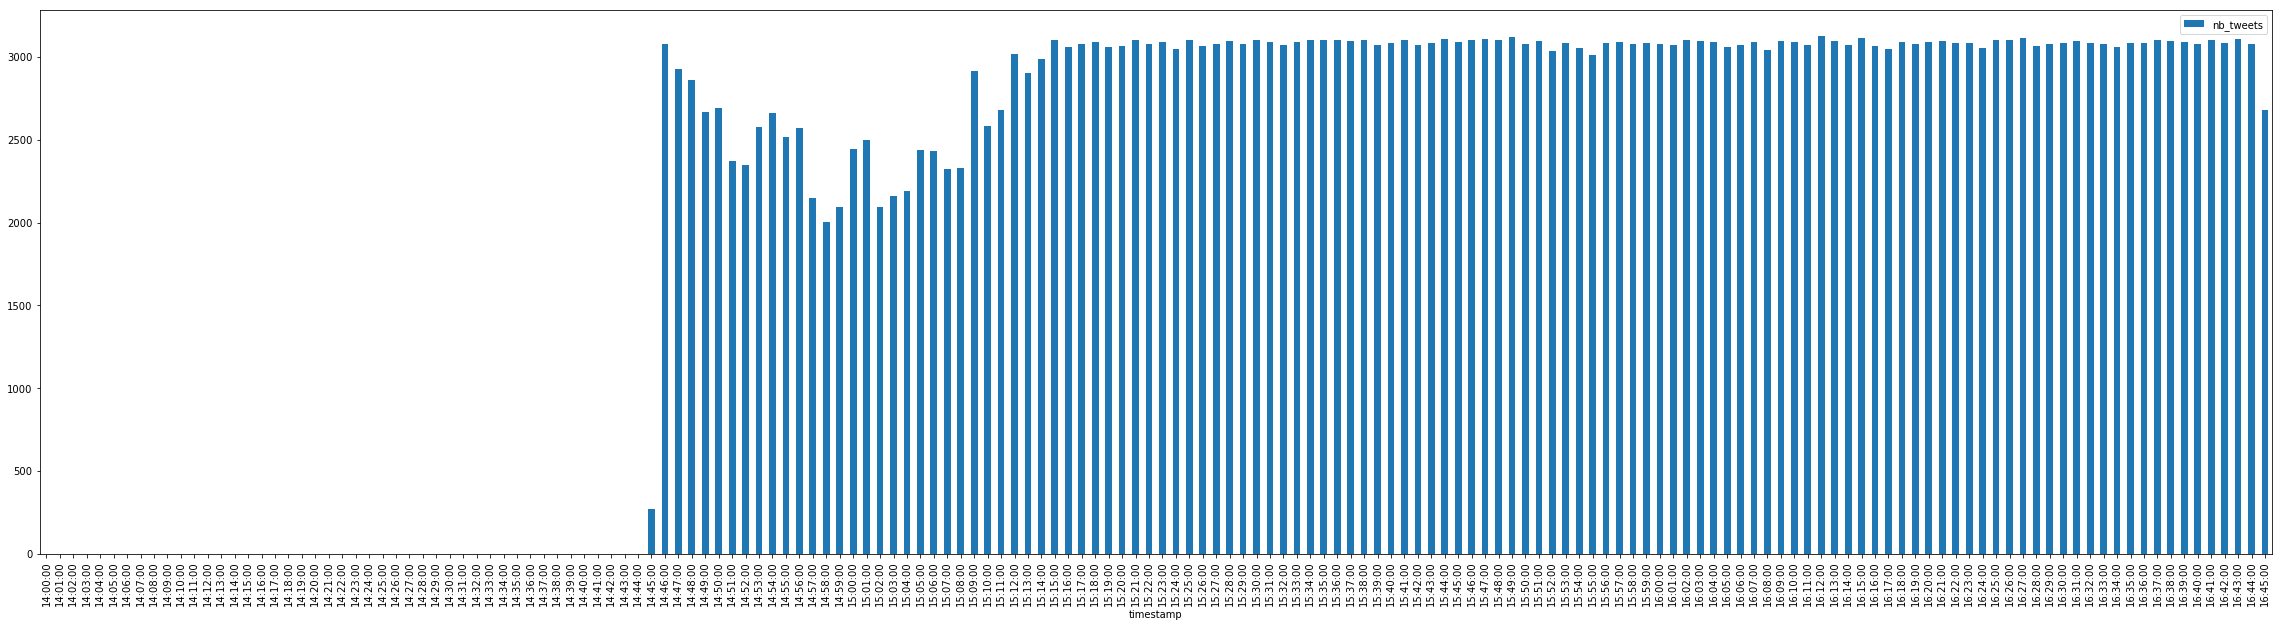

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [82]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"term":{"text":"goal"}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 16771 Hits:
TWEET:Goal goal goal goal goal goal!!!!!!!!!!!!!!!!!!!!!! #RealMadrid #RMALIV #UCLfinal Preveza Epirus: Sat May 26 20:13:28 +0000 2018
TWEET:Goal 
Goal
Goal
Goal
#UCLfinal Olouwadamissi: Sat May 26 19:57:14 +0000 2018
TWEET:GOAL GOAL GOAL GOAL GOOOAAAAL MANEEEEE #UCLFinal NooR: Sat May 26 20:01:07 +0000 2018
TWEET:Super goal goal goal goal goal https://t.co/FVh1CVOEGA Abouuuuuuuuuuuuu Impala: Sat May 26 20:12:56 +0000 2018
TWEET:Goal! Goal!! Goal!!! Sadio Mane #UCLfinal P!: Sat May 26 20:00:31 +0000 2018
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:Goal Goal Goal!!!!! 
@KraksTV 
#UCLFinal https://t.co/H8cDjge8hi Unilag Ajebutter: Sat May 26 19:56:06 +0000 2018
TWEET:Yeyyyy😃😃 goal ,goal😃😃😃
#UCLfinal A girl with a brain without mind.: Sat May 26 20:25:25 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:Mane goal issa goal #uclfin

### 1) ¿Cuántos tweets tienen la palabra "liverpool"? ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)

In [1]:
res = es.search(index="tp5-championstweets", 
                      body={
                          "query":{
                              "match":{
                                  'text':'liverpool'
                              }
                          },
                          "aggs":{
                              "tweets_over_time":{ 
                                  "date_histogram":{
                                      "field":"timestamp","interval":"1m"
                                  }
                              }
                          }
                      }
                     )
df_liverpool= pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_liverpool=df_liverpool.rename(columns={'key': 'tiempo', 'doc_count': 'numeroTweetsPalabraliverpool'})
df_liverpool['tiempo']=df_liverpool['tiempo'].apply(timestamp2date)
df_liverpool=df_liverpool.drop(df_liverpool[df_liverpool.numeroTweetsPalabraliverpool<290].index)
df_liverpool.plot(kind='bar',figsize=(40,10),x='tiempo')
plt.show()

NameError: name 'es' is not defined

### 2) ¿De dónde vienen los tweets? (utilizar el campo 'location')

In [ ]:
res = es.search(index="tp5-championstweets",
                body={
                    "aggs":{
                        "grb":{
                            "terms":{
                                "field": "location.keyword"
                            }
                        }
                    }
                }
               )
df_location=pd.DataFrame(res['aggregations']['grb']['buckets'])
df_location=df_location.rename(columns={'key': 'location', 'doc_count': 'numerotweets'})
df_location.plot(kind="bar",figsize=(40,10),x="location")
plt.show()

### 3) ¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma)

In [ ]:
resgoal = es.search(index="tp5-championstweets",
                    body={
                        "query":{
                            "term":{'text':'goal'}},
                        "aggs":{
                            "tweets_over_time":{
                                "date_histogram":{
                                    "field":"timestamp","interval":"1m"
                                }
                            }
                        }
                    }
                   )
resliverpool=es.search(index="tp5-championstweets",
                       body={
                           "query":{
                               "term":{'text':'liverpool'}},
                           "aggs":{
                               "tweets_over_time":{
                                   "date_histogram":{
                                       "field":"timestamp","interval":"1m"
                                   }
                               }
                           }
                       }
                      )
df_goal=pd.DataFrame(resgoal['aggregations']['tweets_over_time']['buckets'])
df_lv=pd.DataFrame(resliverpool['aggregations']['tweets_over_time']['buckets'])
df_goal=df_goal.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetgoal'})
df_lv=df_lv.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetliverpool'})
df_goal['timestamp']=df_goal['timestamp'].apply(timestamp2date)
df_lv['timestamp']=df_lv['timestamp'].apply(timestamp2date)
df_goalv=pd.merge(df_goal,df_lv,on='timestamp')
df_goalv.plot(kind='bar',figsize=(40,10),x='timestamp')
plt.show()

### 4) Graficar un Pie Chart comparando el número de tweets con: a) la palabra 'liverpool', b) la palabra 'madrid', c) la palabra 'madrid' y 'liverpool' d) ninguna de las palabras

In [ ]:
resmad = es.search(index="tp5-championstweets",
                   body={
                       "query":{
                           "term":{'text':'madrid'}},
                       "aggs":{
                           "tweets_over_time":{
                               "date_histogram":{
                                   "field":"timestamp","interval":"1m"
                               }
                           }
                       }
                   }
                  )
resmal = es.search(index="tp5-championstweets",
                   body={
                       "query":{
                           "match":{'text':'(madrid)+( )* (liverpool)+'}},
                       "aggs":{
                           "tweets_over_time":{
                               "date_histogram":{
                                   "field":"timestamp","interval":"1m"
                               }
                           }
                       }
                   }
                  )
madrid=pd.DataFrame(resmad['aggregations']['tweets_over_time']['buckets'])
mal=pd.DataFrame(resmal['aggregations']['tweets_over_time']['buckets'])
madrid=madrid.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetmadrid'})
mal=mal.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetmadrid + liverpool'})
madrid['timestamp']=madrid['timestamp'].apply(timestamp2date)
mal['timestamp']=mal['timestamp'].apply(timestamp2date)
dff=pd.merge(mal,madrid,on='timestamp')
dff=pd.merge(dff,lv,on='timestamp')
dff[['numerotweetmadrid + liverpool','numerotweetmadrid','numerotweetliverpool']].sum().plot(kind='pie')
plt.show()

### 5) ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido.

In [ ]:
feliz = es.search(index="tp5-championstweets",
                  body={
                      "query":{
                          "match":{'text':'feliz'}}
                  }
                 )
triste= es.search(index="tp5-championstweets",
                  body={
                      "query":{
                          "match":{'text':'triste'}
                      }
                  }
                 )
enojado=es.search(index="tp5-championstweets",
                  body={
                      "query":{
                          "match":{'text':'enojado'}
                      }
                  }
                 )
sorprendido=es.search(index="tp5-championstweets",
                      body={
                          "query":{
                              "match":{'text':'sorprendido'}
                          }
                      }
                     )
emociones={'totalfeliz':[feliz['hits']['total']],'totaltriste':[triste['hits']['total']],'totalenojado':[enojado['hits']['total']]
          ,'totalsorprendido':[sorprendido['hits']['total']]}
emociondata=pd.DataFrame(data=emociones)
emociondata.sum().plot(kind='pie')
plt.show()